In [1]:
import numpy as np
import os.path
import sys
#sys.path.append('../../libs/neuroneap') #('../../libs/')
#sys.path.append('../../mylibs')
sys.path.append('libs/neuroneap') #('../../libs/')
sys.path.append('mylibs')

import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

#import mylibs.plot_supp as pls

%matplotlib inline

# LFP
from eap import field, cell, graph
postfixes = ['','_noAIS'] #, '_noAIS'] #_noAIS_noNode' # '_noAIS' ''
data_type = 'NoR' #'NoR' '' '_zoom' 'lfp_zoom_high' 'lfp_zoom_out', 'calc_ais_area_det' '150_ais_area'

In [2]:
# params
ext = '.pdf'
plot_lim = [-2,2] #ms,  x_axis from the peak of the somatic spike
save_fig_dir = 'figs/'
save_movie_dir = 'figs/'

axon_color = 'teal'
soma_color = 'darkorange'

# define colormap 
mycmap = plt.cm.get_cmap('RdYlGn')

ais_coord = [-8.10, -69.90]
nor = [-3.18, -182]
colors = ['red', 'green', 'blue' , 'magenta', 'black']

## load the data

In [3]:

data = np.load('data/data_hallerman'+postfixes[0]+'.npz')
lfp_datas = []
for idx in range(len(postfixes)):
    print 'data/lfp'+data_type+postfixes[idx]+'.npz'
    lfp = np.load('data/lfp'+postfixes[idx]+data_type+'.npz')
    lfp_datas.append(lfp)

data/lfpNoR.npz
data/lfpNoR_noAIS.npz


## find the spike and calculate params

In [4]:
# to do
# find the limits for xlims
def find_spike(volt, dt):
    #v_soma = data['v_soma']
    #dt = data['dt']
    spike_peak = np.argmax(volt)*dt

    #plot_lim = spike_peak+plot_lim
    return spike_peak

In [5]:
# define timeline and get seg_coords (assumed that they are all the same 
# in all of the datas used)
dt = data['dt']
time = np.arange(len(data['v_soma']))*dt
seg_coords = data['seg_coords']

y1_ais = seg_coords[seg_coords['name'] == 'axon[0]'][-1]['y1']
x1_ais = seg_coords[seg_coords['name'] == 'axon[0]'][-1]['x1']

## field potential

In [6]:
def plot_scalebar(ax, scalebar = 100, xp = 100, yp = -100):
# scalebar
    w, h = scalebar, scalebar
    plt.plot([xp, xp], [yp, yp+h], 'k-')
    plt.plot([xp, xp+h], [yp, yp], 'k-')
    plt.text(xp, yp+h/2., str(scalebar) +u" µm", ha='right', va='center',
             transform=ax.transData)
    plt.text(xp+h/2., yp, str(scalebar) + u" µm", ha='center', va='top',
             transform=ax.transData)

In [7]:
def get_lfp_data(data_ext):
    #data_ext = np.load(lfp_file)
    
    v_ext = data_ext['v_ext']
    x_range = data_ext['x_range']
    y_range = data_ext['y_range']
    yy = data_ext['yy']
    xx = data_ext['xx']
    print data_ext, x_range, y_range
    return v_ext, x_range, y_range, xx, yy

In [8]:
def plot_all_v_ext(v_ext, timeline, color = 'blue', label = '', yzoom = [-100000, 50000],
                  clean_plot = False):
    idx = 0
    xlim = [40,56]
    scale = 2
    for i in range(1, np.size(v_ext,1)+1)[::-1]:
        for j in range(1,np.size(v_ext, 2)+1):
            idx+=1
            ax = plt.subplot(np.size(v_ext,1), np.size(v_ext, 2), idx)
            plt.hlines(0, timeline[0], timeline[-1], linestyles = 'dashed', colors = 'k')

            plt.plot(timeline, v_ext[:,i-1,j-1], color = color, label = label)
            plt.plot([49, 49], [-0.5*scale,0.5*scale], color='m', lw=2)
            if i == 1 and j == 5:
                plt.text(15, 30, u'scale='+str(scale)+u'µV')
            #plt.ylim(np.min(v_ext), np.max(v_ext))
            # Hide the right and top spines
            #plt.ylim(yzoom)
            #
            #print labels
            #max_y = np.max(np.abs(labels[0]), labels[-1])
            #plt.xlim([42.001,50])
            plt.xlim(xlim)
            if clean_plot:
                labels=ax.get_yticks().tolist()
                max_plot = max(np.abs(labels))
                yzoom = [-max_plot, max_plot]
                plt.ylim(yzoom)
                if idx %5 == 1 or idx in [21, 22, 23, 24, 25]:
                    ax.spines['right'].set_visible(False)
                    ax.spines['top'].set_visible(False)
                    if idx %5 == 1:
                        labels=ax.get_yticks().tolist()
                        ax.yaxis.set_ticks_position('left')
                        #labels = [item.get_text() for item in ax.get_yticklabels()]
                        idx_0 = labels.index(0.0)
                        labels[1:-1] = ['']*len(labels[1:-1])
                        labels[idx_0] = 0
                        ax.set_yticklabels(labels)
                        
                        ax.spines['left'].set_visible(False)
                        ax.set_yticks([]) 
                    else:

                        ax.spines['left'].set_visible(False)
                        ax.set_yticks([]) 

                    if idx in [21, 22, 23, 24, 25]:
                        ax.xaxis.set_ticks_position('bottom')
                        locs = np.arange(xlim[0],xlim[-1],step=5) # locations
                        ticks = np.arange(0,np.diff(xlim),step=5)
                        plt.xticks(locs, ticks)#, rotation="vertical" )
                        ax.set_xlabel('time (ms)')
                    else:
                        ax.spines['bottom'].set_visible(False)
                        ax.set_xticks([]) 
                else:
                    plt.axis('off')
                plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.1)

In [9]:
if data_type == '_zoom' or data_type == '':
    # draw LFP for different models
    
    clean_plot = False
    #ymax = 
    for idx in range(len(lfp_datas)):
        v_ext, x_range, y_range, xx, yy = get_lfp_data(lfp_datas[idx])
        v_ext_um = v_ext/10e2 # change to microvolts
        timeline = np.arange(0, len(v_ext_um)*dt, dt)

        if idx == len(lfp_datas) -1:
            clean_plot = True
        plot_all_v_ext(v_ext_um,timeline, color=colors[idx],label=postfixes[idx],clean_plot=clean_plot)#, yzoom = yzoom, clean_plot = False)
    
    plt.legend(frameon = False, loc = "center left", bbox_to_anchor = (1, 0.5))

    plt.title(data_type)
    plt.savefig('figs/traces_all_models'+data_type+ext)

In [10]:
# plot the imshow of the given field (2d array)
def imshow_data(ax, data, x_range, y_range, vmin=0, vmax=100, cmap=cm.YlOrRd,
               scalebar=100, xp_scbar=20, yp_scbar=-50, log=False, 
                autolim = True):    

    plt.sca(ax)
    if log:
        pl = plt.imshow(data, interpolation="nearest", 
           extent=(x_range[0], x_range[1], y_range[0], y_range[1]), 
           origin='lower', vmin=vmin, vmax=vmax, cmap=cmap,
            norm=colors.SymLogNorm(linthresh=0.01 * np.max(data),
                                                linscale=1.0,
                                                vmin=vmin, vmax=vmax))
    else:
        pl = plt.imshow(data, interpolation="nearest", 
           extent=(x_range[0], x_range[1], y_range[0], y_range[1]), 
           origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)     
    
    
    
    if scalebar != None:
        plot_scalebar(ax, scalebar=scalebar,xp=xp_scbar,yp=yp_scbar)
    graph.plot_neuron(seg_coords, colors='0.4', autolim = autolim)
    ax.axis('off')
    ax.set_ylim(y_range)
    ax.set_xlim(x_range)
    plt.tight_layout()

In [11]:
def mask_data(data, xmask_range, ymask_range):
    data_masked = data.copy()
    x_len = np.diff(xmask_range)
    y_len = np.diff(ymask_range)
    data_masked[xmask_range[0]:xmask_range[1],ymask_range[0]:ymask_range[1]] = np.zeros([x_len, y_len])
    return data

In [12]:
# data should be 3d, max is calculated on 0 axis
def calc_max_peak2peak(data):
    data_max = np.nanmax(data, axis=0)
    data_min = np.nanmin(data, axis=0)
    data_ampl = data_max - data_min
    return data_ampl

In [13]:
def clean_frame(ax):
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)     

In [14]:
v_exts_um = []
amplitudes = []

# get the lfp datas and calculate amplitudes
for idx in range(len(lfp_datas)):
    print idx
    v_ext, x_range, y_range, xx, yy = get_lfp_data(lfp_datas[idx])
    
    amplitude = calc_max_peak2peak(v_ext)
    amplitude = amplitude/10e2 # change to microvolts
    #v_ext_um = v_ext/10e2 # change to microvolts
    
    #v_exts_um.append(v_ext_um)
    amplitudes.append(amplitude)
    v_ext = None

0
<numpy.lib.npyio.NpzFile object at 0x7f2673f90d90> [-50  50] [-300   10]
1
<numpy.lib.npyio.NpzFile object at 0x7f2673f90e50> [-50  50] [-300   10]


In [15]:
np.shape(v_ext)

()

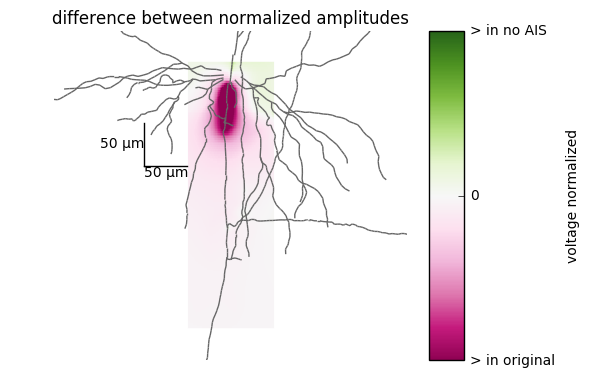

In [16]:
# plot the difference between two normalized extracellular voltages
if len(amplitudes) == 2:
    # plot the difference between the two
    vmin, vmax = -0.1, 0.1
    ticks = [-0.1, 0, 0.1]
    str_ticks = ['> in original ', '0', '> in no AIS']

    from matplotlib import gridspec
    gs = gridspec.GridSpec(1, 2, width_ratios=(3 ,0.3))
    #f, axes = plt.subplots(1, len(lfp_datas)+1) #, sharey=True)
    #fig, axes = plt.subplots(figsize=(8, 3), ncols=2)
    scalebar = 50

    # normalize
    max_ampl = np.max(np.abs(amplitudes[0]))
    ampl_diff0 = amplitudes[0]/max_ampl

    max_ampl = np.max(np.abs(amplitudes[1]))
    ampl_diff1 = amplitudes[1]/max_ampl

    # subtract one from the other
    ampl_diffs = ampl_diff1-ampl_diff0

    ax = plt.subplot(gs[0,0])

    im = imshow_data(ax,ampl_diffs,x_range=x_range,y_range=y_range,
                vmin=vmin,vmax=vmax,cmap=cm.PiYG,scalebar=scalebar,
                         xp_scbar=-100, yp_scbar=-110)
    plt.title('difference between normalized amplitudes')

    # add colorbar
    axes = plt.subplot(gs[0,1])
    cbar = plt.colorbar(im, cax=axes, drawedges = False, ticks=ticks)
    cbar.ax.set_yticklabels(str_ticks)
    cbar.ax.set_ylabel(u'voltage normalized')

    plt.tight_layout()
    plt.savefig(b'figs/norm_ampl_difference'+data_type+ext)

In [17]:
normalize = False
if data_type == '' or data_type == 'lfp_zoom_out':
    vmax = 150
    ticks = [0, 50, 100, 150]
    str_ticks = [str(0), '50', '100', '>150']
else:
    vmax = 1000
    ticks = [0, 250, 500, 750, 1000]
    str_ticks = [str(0), '250', '500', '750', '>1000']
    normalize = False
if normalize:
    vmax = 0.5
    ticks = [0, 0.5]
    str_ticks = [str(0), '>0.5']

In [18]:
v_ext, v_soma, v_ais, data = None, None, None, None
#plt.imshow(v_ext)
#plt.colorbar()
#print np.shape(lfp_datas[0]['v_ext'])

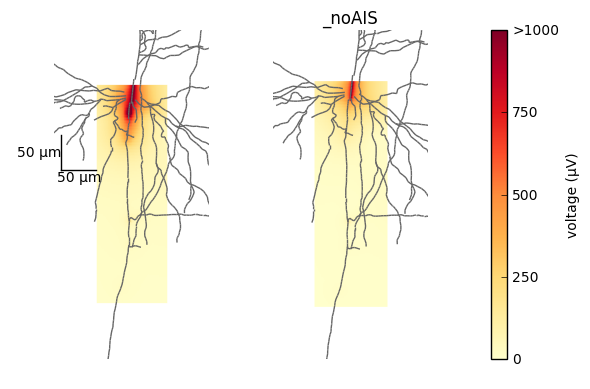

In [19]:
# plot the extracellular voltage
from matplotlib import gridspec
gs = gridspec.GridSpec(1, 3, width_ratios=(3, 3 ,0.3))
#f, axes = plt.subplots(1, len(lfp_datas)+1) #, sharey=True)
#fig, axes = plt.subplots(figsize=(8, 3), ncols=2)
scalebar = 50
for idx in range(len(lfp_datas)):
    #v_ext, x_range, y_range, xx, yy = get_lfp_data(lfp_datas[idx])
    #v_ext_um = v_ext/10e2 # change to microvolts

    #amplitude = calc_max_peak2peak(v_ext_um)
    #v_ext_um = v_exts_um[idx]
    amplitude = amplitudes[idx]
    
    if normalize:
        max_ampl = np.max(np.abs(amplitude))
        amplitude = amplitude/max_ampl
    
    ax = plt.subplot(gs[0,idx])

    im = imshow_data(ax,amplitude,x_range=x_range,y_range=y_range,
            vmin=0,vmax=vmax,cmap=cm.YlOrRd,scalebar=scalebar,
                     xp_scbar=-100, yp_scbar=-110)
    
    # if zoom out draw also the horizontal and vertical lines
    if data_type == 'lfp_zoom_out' or data_type == '':
        plt.hlines(0, x_range[0], x_range[1], color = colors[idx], linestyles='--')
        plt.vlines(0, y_range[0], y_range[1], color = colors[idx], linestyles='--')
        plt.hlines(ais_coord[1], x_range[0], x_range[1], color = colors[idx], linestyles='--')
        plt.hlines(200, x_range[0], x_range[1], color = colors[idx], linestyles='--')
        plt.hlines(-200, x_range[0], x_range[1], color = colors[idx], linestyles='--')
    elif data_type == 'lfp_zoom_high'or data_type == '_zoom'or data_type == 'calc_ais_area_det':
        # add the location of AIS
        plt.plot(ais_coord[0], ais_coord[1], 'or', ms = 8, mfc='none', mec = 'r')
    scalebar = None
    plt.title(postfixes[idx])
    plt.tight_layout()

# add colorbar
axes = plt.subplot(gs[0,2])
cbar = plt.colorbar(im, cax=axes, drawedges = False, ticks=ticks)
cbar.ax.set_yticklabels(str_ticks)
cbar.ax.set_ylabel(u'voltage (µV)')
plt.tight_layout()

if normalize: 
    plt.savefig(b'figs/max_signal_ampl_norm'+data_type+ext)
else:
    plt.savefig(b'figs/max_signal_ampl'+data_type+ext)

In [20]:
def calc_fraction(pt=0,no_segs = 5,line_range=[-200,300]):
    x_min, x_max = line_range
    
    if pt == x_min:
        return 0
    elif pt == x_max:
        return no_segs-1
    delta_x = np.diff(line_range)*1.0/no_segs
    n_x = int((pt-x_min)/delta_x)
    assert n_x < no_segs
    return n_x    

In [21]:
pts_y = np.array([0, ais_coord[1], 200, -200])
if (pts_y >= y_range[0]).all() and (pts_y <= y_range[1]).all():
    print 1
    
    

In [22]:
#print np.shape(amplitudes), np.shape(max_ampl_v)
#print frac
#amplitudes[0][:,frac] = amplitudes[0][:,frac]/max_ampl_v[0]
#amplitudes[1][:,frac] = amplitudes[1][:,frac]/max_ampl_v[1]
#print np.shape(amplitudes[0][:,frac]), np.shape(max_ampl_v[0])
#amplitudes[:,:,0]

In [23]:
# calculates the distance voltage relationships

pts_y_h = np.array([0, -60, 200, -200]) #ais_coord[1], 200, -200])
pts_y_v = np.array([0])
fig = plt.figure() #figsize=(4, 8))

# normalize amplitudes to largest between the models
max_ampl_v = np.max(amplitudes,2)
max_ampl_h = np.max(amplitudes,1)

subplots = [2,3] #[len(pts_y_h)+len(pts_y_v), 2]
plot_norm_ampl = True

if (pts_y >= y_range[0]).all() and (pts_y <= y_range[1]).all():
    # plot all the horizontal plots
    idx = 1
    lin_range_x = np.linspace(x_range[0], x_range[1],np.size(amplitudes,1))
    lin_range_y = np.linspace(y_range[0], y_range[1],np.size(amplitudes,2))
    
    for pt_h in pts_y_h:
        
        frac = calc_fraction(pt=pt_h,no_segs=np.size(amplitudes,1),
                           line_range=x_range)
        
        # plot it
        ax = plt.subplot(subplots[0],subplots[1], idx)
        idx+=1
        #line_1divr2 = 1./np.abs(lin_range_x ** 2) #**(2)) 
        
        if plot_norm_ampl:
            max1 = np.max(amplitudes[0][frac,:])
            max2 = np.max(amplitudes[1][frac,:])
            max_frac = np.max([max1, max2])
            ampl_norm_0 = amplitudes[0][frac,:]/max_frac
            ampl_norm_1 = amplitudes[1][frac,:]/max_frac
            ax.plot(lin_range_x, ampl_norm_0, colors[0], label=postfixes[0]) 
            ax.plot(lin_range_x, ampl_norm_1, colors[1], label=postfixes[1])  
        else:
            ax.plot(lin_range_x, amplitudes[0][frac,:], colors[0], label=postfixes[0]) 
            ax.plot(lin_range_x, amplitudes[1][frac,:], colors[1], label=postfixes[1])  
        
        #draw line 1/r2
        #ax.plot(lin_range_x, line_1divr2, 'b')#, label=postfixes[0]) 
        plt.title(pt_h)
        #ax1.set_ylim([0.1, vmax])
        ax.set_yscale('log')
        #ax.set_xscale('log')
        ax.set_xlim([lin_range_x[0], lin_range_x[-1]])
        ax.set_xlabel(u'space (µm)')
        ax.set_ylabel(u'voltage (normalized)')
        for label in ax.xaxis.get_ticklabels()[1::2]:
            # label only every second tick
            label.set_visible(False)
        clean_frame(ax)
        
    for pt_v in pts_y_v:
        frac = calc_fraction(pt=pt_v,no_segs=np.size(amplitudes,2),
                           line_range=y_range)
        # normalize

        
        ax = plt.subplot(subplots[0],subplots[1], idx)
        idx+=1
        if plot_norm_ampl:
            max1 = np.max(amplitudes[0][:,frac])
            max2 = np.max(amplitudes[1][:,frac])
            max_frac = np.max([max1, max2])
            ampl_norm_0 = amplitudes[0][:,frac]/max_frac
            ampl_norm_1 = amplitudes[1][:,frac]/max_frac
            plt.plot(ampl_norm_0,lin_range_y, colors[0])
            plt.plot(ampl_norm_1,lin_range_y, colors[1])
        else:
            plt.plot(amplitudes[0][:,frac],lin_range_y, colors[0])
            plt.plot(amplitudes[1][:,frac],lin_range_y, colors[1])
        ax.set_xscale('log')
        plt.title(pt_v)
        ax.set_ylim([lin_range_y[0], lin_range_y[-1]])
        ax.set_ylabel(u'space (µm)')
        ax.set_xlabel(u'voltage (normalized)')
        clean_frame(ax)
    
    plt.tight_layout()
    plt.savefig(b'figs/Peak_peak'+data_type+ext)

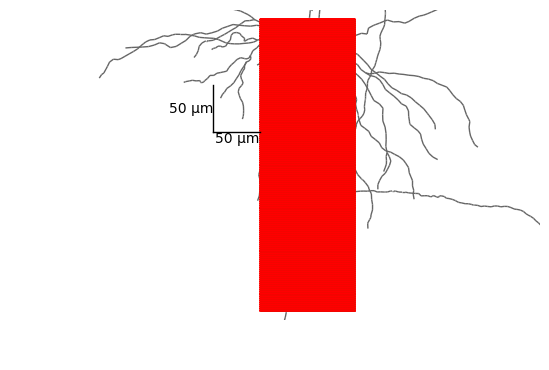

In [24]:
# plot neurons shape
ax = plt.subplot(111)
graph.plot_neuron(seg_coords, colors='0.4')
# plot field potential
#plt.imshow((v_ext[time_pt,:,:]), interpolation="nearest", extent=(x_range[0], x_range[1], y_range[0], y_range[1]), origin='lower')
plt.plot(xx,yy, 'g*', ms=2, markeredgecolor='r')
ax.axis('off')
## insets with extracellular potential shapes
#axs = graph.plot_multiplies(xx, yy, v_ext, t, sharey=True)
#cbar = plt.colorbar()

plot_scalebar(ax, scalebar = 50, xp = -100, yp = -110)
plt.xlabel(r'$\mu m$')
plt.ylabel(r'$\mu m$')
#ax.set_ylim([y_range[0]-10, y_range[1]+10])
#ax.set_xlim([x_range[0]-10, x_range[1]+10])
ax.set_ylim([y_range[0]-10, y_range[1]+10])
ax.set_xlim([x_range[0]-10, x_range[1]+10])
plt.plot(ais_coord[0], ais_coord[1], 'or', ms = 8, mfc='none', mec = 'r')

#cbar.ax.set_ylabel('nV')
plt.savefig('figs/lfp'+data_type+ext)

In [25]:
axon_color = 'teal'
soma_color = 'darkorange'
NoR_color = 'mediumpurple'
v_ext, v_soma, v_ais, data = None, None, None, None
v_ext = None
x_range_plt = [-200, 200]#[-10,10]
y_range_plt = [-200, 200]#[-100,0]
vmin, vmax = -150,150
plt.figure(figsize=(8, 10))
pt1 = -0.15
pt3 = 0.4
streamplt_density = 0.4
scalebar = 10
if len(postfixes) <= 2:
    gs = gridspec.GridSpec(4, 3, width_ratios=(3, 3 ,0.3))
    for idx in range(len(postfixes)):
        data = np.load('data/data_hallerman'+postfixes[idx]+'.npz')
        dt = data['dt']
        v_soma = data['v_soma']
        v_ais = data['vecs_ais'][-1]
        time = np.arange(len(data['v_soma']))*dt
        ### draw spikes
        ax = plt.subplot(gs[0,idx])
        plt.plot(time, v_soma, color=soma_color, label = 'soma')
        plt.plot(time, v_ais, color=axon_color, label = 'ais')
        if idx == 1:
            plt.legend(frameon = False)

        spike_peak = find_spike(v_ais, dt)
        plt.vlines(spike_peak, -100, 40, linestyles='--')
        line2 = int(spike_peak/dt)
        plt.vlines(spike_peak+pt1, -100, 40, linestyles='--')
        line1 = int((spike_peak+pt1)/dt)
        plt.vlines(spike_peak+pt3, -100, 40, linestyles='--')
        line3 = int((spike_peak+pt3)/dt)
        plt.title(postfixes[idx])
        
        clean_frame(ax)
        plt.xlim([spike_peak-1.5, spike_peak+1.5])
        plt.ylim([-100,40])
        
        ### get extracellular data
        v_ext, v_soma, v_ais, data = None, None, None, None
        v_ext1 = lfp_datas[idx]['v_ext'][line1, :,:]/10e2 # change to microvolts
        v_ext2 = lfp_datas[idx]['v_ext'][line2, :,:]/10e2
        v_ext3 = lfp_datas[idx]['v_ext'][line3, :,:]/10e2

        xx = lfp_datas[idx]['xx']
        yy = lfp_datas[idx]['yy']
        
        ### draw the v_ext at the first timept
        ax1 = plt.subplot(gs[1,idx])
        im = imshow_data(ax1,v_ext1,x_range=x_range,y_range=y_range,
                vmin=vmin,vmax=vmax,cmap=cm.bwr,scalebar=scalebar,
                         xp_scbar=40, yp_scbar=20,autolim = False)
        U = -np.diff(v_ext1, axis=0)[:, :-1]
        V = -np.diff(v_ext1, axis=1)[:-1, :]
        
        plt.axis('scaled')
        plt.plot(ais_coord[0], ais_coord[1], 'ob', ms = 8, mfc='none', mec = 'r')
        plt.streamplot(xx[0, :-1], yy[:-1, 0], V, U, density = streamplt_density, color = 'k', linewidth=0.5)
        
        ax2 = plt.subplot(gs[2,idx])
        #clean_frame(ax)
        im = imshow_data(ax2,v_ext2,x_range=x_range,y_range=y_range,
                vmin=vmin,vmax=vmax,cmap=cm.bwr,scalebar=scalebar,
                         xp_scbar=40, yp_scbar=20,autolim = False)
        U = -np.diff(v_ext2, axis=0)[:, :-1]
        V = -np.diff(v_ext2, axis=1)[:-1, :]
        plt.axis('scaled')
        plt.plot(ais_coord[0], ais_coord[1], 'ob', ms = 8, mfc='none', mec = 'r')
        plt.streamplot(xx[0, :-1], yy[:-1, 0], V, U, density = streamplt_density, color = 'k', linewidth=0.5)
        
        #ax3 = plt.subplot(4,2,idx+7)
        
        ax3 = plt.subplot(gs[3,idx])
        U = -np.diff(v_ext3, axis=0)[:, :-1]
        V = -np.diff(v_ext3, axis=1)[:-1, :]
        plt.streamplot(xx[0, :-1], yy[:-1, 0], V, U, density = streamplt_density, color = 'k', linewidth=0.5)
 
        im = imshow_data(ax3,v_ext3,x_range=x_range,y_range=y_range,
            vmin=vmin,vmax=vmax,cmap=cm.bwr,scalebar=scalebar,
                     xp_scbar=40, yp_scbar=20,autolim = False)   
        
        plt.axis('scaled')
        plt.plot(ais_coord[0], ais_coord[1], 'ob', ms = 8, mfc='none', mec = 'r')
        plt.plot(-3.18, -182, 'ob', ms = 8, mfc='none', mec = 'g') # 1st NoR
        # 1st Nor coords -3.18, -182           
        #v_ext_um = v_ext/10e2 # change to microvolts
        #timeline = np.arange(0, len(v_ext_um)*dt, dt)

    ax_col = plt.subplot(gs[1,2])
    str_ticks = ['<'+str(vmin), '', '>'+str(vmax)]
    ticks = [vmin, 0, vmax]
    cbar = plt.colorbar(im, cax=ax_col, drawedges = False, ticks=ticks) #, cax=ax_col, drawedges = False) #, ticks=ticks)
    
    cbar.ax.set_ylabel(u'voltage (µV)')
    cbar.ax.set_yticklabels(str_ticks)
    plt.tight_layout()
    plt.savefig('figs/dipoles'+data_type+ext)

In [26]:
print np.shape(v_ext)
#graph.plot_neuron(seg_coords, autolim=True) #, colors='0.4', autolim = autolim)
#plt.imshow(v_ext1)
im = imshow_data(ax3,v_ext3,x_range=x_range,y_range=y_range,
            vmin=vmin,vmax=vmax,cmap=cm.bwr,scalebar=scalebar,
                     xp_scbar=40, yp_scbar=20,autolim = False)  
plt.streamplot(xx[0, :-1], yy[:-1, 0], V, U, density = 1.0, color = 'k')

()


ValueError: Axes instance argument was not found in a figure.

In [27]:
def find_pt_in_new_range(old_range, new_range, old_pt):
    #assert old_pt <= old_range[1] and old_pt >=old_range[0]
    old_size = np.diff(old_range)
    old_frac = (old_pt-old_range[0])/(old_size*1.0)
    
    #assert old_frac >=0 and old_frac <= 1.
    
    new_size = np.diff(new_range)
    new_frac = new_size*old_frac
    new_pt = new_range[0]+new_frac
    return new_pt[0] 
#find_pt_in_new_range([0,10], [-5,5], -1)

In [41]:
axon_color = 'teal'
soma_color = 'darkorange'
NoR_color = 'mediumpurple'

# calculate and plot CSD at pt = pt
pt = ais_coord[0]
plt.figure(figsize = (15,6))
plt.subplot(1, len(postfixes)+1, 1)
graph.plot_neuron(seg_coords, colors='0.4', autolim = True)
y_ticks_neuron = ax.get_xticks().tolist()
plt.ylim(y_range)
plt.xlim(x_range)
plt.plot(ais_coord[0], ais_coord[1], 'ob', ms = 8, mfc='none', mec = 'r')
plt.plot(-3.18, -182, 'ob', ms = 8, mfc='none', mec = 'g') # 1st NoR
plt.plot(-3.92, -216.50, 'ob', ms = 8, mfc='none', mec = 'g') # 2nd NoR
plt.plot(-15.48, -278.20, 'ob', ms = 8, mfc='none', mec = 'g') # 3rd NoR

t_range = [-0.6,0.7]

for idx in range(len(postfixes)):
    data = np.load('data/data_hallerman'+postfixes[idx]+'.npz')
    v_ext = lfp_datas[idx]['v_ext']
    frac = calc_fraction(pt=pt,no_segs=np.size(v_ext,1),
                           line_range=x_range)
    csd = np.diff(v_ext[:,:, frac], n=2)
    
    
    # find peak of the spike in ais and in the soma
    v_ais = data['vecs_ais'][-1]
    v_soma = data['v_soma']
    #time = np.arange(len(data['v_soma']))*dt

    spike_peak_ais = find_spike(v_ais, dt)
    spike_peak_soma = find_spike(v_soma, dt)
    
    plt.subplot(1, len(postfixes)+1, idx+2)
    #graph.plot_neuron(seg_coords, colors='0.4', autolim = True)
    # make a range for plotting 
    plot_range = [int(i) for i in ((spike_peak_ais+t_range)/dt)]
    ax = plt.gca()
    mat = ax.imshow(csd[plot_range[0]:plot_range[1]].T[::-1], extent=np.r_[spike_peak_ais+t_range, y_range], aspect='auto',
              cmap = cm.PiYG_r, vmin= -100, vmax=100) #, norm=LogNorm(vmin=0.01, vmax=1))
        
    #PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
    plt.colorbar(mat) 

    
    #ax.set_aspect(5)
    
    #ticks_old = ax.get_xticks().tolist()
    #print ticks_old
    #ticks_new = ticks_old * dt + timept_range[0] *dt
    
    #x_ticks = np.linspace(timept_range[0],timept_range[1], 4)
    #x_ticks = np.round(x_ticks, 1)

    #ticks = np.linspace(ticks_old[0], ticks_old[-1], 4)
    
    #ax.set_xticklabels(x_ticks*dt)
    #for label in ax.xaxis.get_ticklabels()[1::2]:
    #    label.set_visible(False)
    
    #ticks = np.linspace(0, np.size(csd,1),5)
    #ax.set_yticks(ticks) 
    #ticks_old = ax.get_yticks().tolist()
    #old_range = [0, np.size(csd,1)][::-1]
    plt.xlabel('time (ms)')
    #new_ticks = [int(find_pt_in_new_range(old_range, y_range, old_pt)) for old_pt in ticks_old]
    
    #ticks_old = ax.get_yticks().tolist()
    #ticks_new = np.linspace(y_range[0], y_range[1], len(ticks_old))
    #ax.set_yticks()
    #ax.set_yticklabels(new_ticks)#ticks_new[::-1])
    plt.ylabel(u'space (µm)')
    #clean_frame(ax)
    #plt.plot(200, ais_coord[1], 'ob', ms = 8, mfc='none', mec = 'r')
    #plt.plot(200, -182, 'ob', ms = 8, mfc='none', mec = 'g') # 1st NoR
    #ax.colorbar()
    #plt.plot(csd)
    #print find_pt_in_new_range(y_range, old_range, ais_coord[1])
    #print timept_range[0]*dt, timept_range[1]*dt
    #print ax.get_xticks().tolist()    

    #plt.vlines(spike_peak_ais, y_range[0], y_range[1], color = axon_color)
    #plt.vlines(spike_peak_soma, y_range[0], y_range[1], color = soma_color)
    plt.vlines(spike_peak_ais+pt1, y_range[0], y_range[1], linestyles='--')
    plt.vlines(spike_peak_ais+0, y_range[0], y_range[1], linestyles='--')
    plt.vlines(spike_peak_ais+pt3, y_range[0], y_range[1], linestyles='--')

    #plt.hlines(find_pt_in_new_range(y_range, old_range, 0), 0, np.diff(timept_range),linestyles='--',colors='0.5')
    #plt.hlines(find_pt_in_new_range(y_range, old_range, ais_coord[1]), 0, np.diff(timept_range),linestyles='--',colors='r')
    #plt.hlines(find_pt_in_new_range(y_range, old_range, nor[1]), 0, np.diff(timept_range),linestyles='--',colors='g')
#plt.tight_layout()

plt.savefig('figs/csd'+ext)

# jeszcze dorobic: a) vertical axis where we measure
# b) vertical axis where is the peak of the AP in the soma and in the AIS, horizotal axis: where is AIS, soma and NoRs

In [32]:
np.r_[spike_peak_ais+t_range, y_range]
#plt.matshow(csd[timept_range[0]:timept_range[1]].T[::-1],   aspect='auto'b)
#print spike_peak_ais+t_range
#print (spike_peak_ais+t_range)/dt
#print [int(i) for i in ((spike_peak_ais+t_range)/dt)]
#print plot_range 
#np.shape(csd[plot_range])

array([  44.69,   45.99, -300.  ,   10.  ])

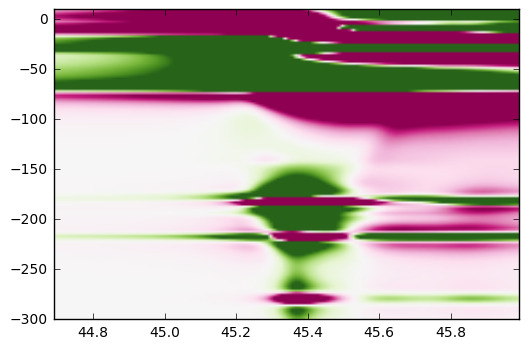

In [39]:
ax = plt.subplot(111)
ax.imshow(csd[plot_range[0]:plot_range[1]].T[::-1], extent=np.r_[spike_peak_ais+t_range, y_range], aspect='auto',
              cmap = cm.PiYG_r, vmin= -100, vmax=100) #, norm=LogNorm(vmin=0.01, vmax=1))

In [ ]:
#plt.contourf(v_ext[timept_range[0] + 225, :, :])

In [ ]:
csd.shape

In [ ]:
plt.contourf(csd[timept_range[0]:timept_range[1]].T, 100)

In [ ]:
csd.shape

In [ ]:
yy = lfp_datas[idx]['yy']


In [ ]:
plt.plot(yy[:-2, 1], np.diff(v_ext[:,:, frac], n=2)[timept_range[0]+225, :])plt.ylim(-1000, 1000)

In [ ]:

plt.plot(yy[:-2, 1], csd[timept_range[0]+225, :], '.')

In [ ]:
plt.plot(yy[:, 1], v_ext[timept_range[0]+225, :, :])

In [ ]:
x_range

In [ ]:
plt.imshow

In [ ]:
np.size(csd,1)
print np.diff(timept_range)

In [ ]:
400*dt
print y_range
print ais_coord[1]

In [ ]:
np.linspace(1,2,3)